## Clustering Dimension 5: Geographic/Market Clusters
Purpose: Group songs by their geographic appeal and market reach

Features to Use:
- Number of nationalities represented (artists)
- Continent of origin
- International collaboration (yes/no)
- Geographic diversity score
- Points from international markets


Clustering Method: K-Means (K=4-5)
Expected Clusters:
- "Global Hit" (multiple continents, diverse nationalities)
- "Regional Specialist" (concentrated in one region)
- "Western-Dominated" (primarily US/UK/Europe)
- "Cross-Cultural Fusion" (international collaborations)
- "Local Hero" (single nationality, strong regional presence)


What This Tells Us: Market appeal and cultural positioning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import joblib
from datetime import datetime

from scipy.stats import entropy

sns.set(style="whitegrid")


In [2]:
DATA_DIR = r"data\Spotify_Dataset_V3.csv"   # change to where you unzipped the dataset
df = pd.read_csv(DATA_DIR, delimiter= ';', low_memory=False)

In [3]:
# Helper to find columns by common names
cols_lower = {c.lower(): c for c in df.columns}
def find_col(possible_names):
    for n in possible_names:
        if n.lower() in cols_lower:
            return cols_lower[n.lower()]
    return None

# Candidate columns (adjust if your CSV uses different names)
COL_DATE = find_col(["date", "Date"])
COL_ID = find_col(["id", "track id", "track_id", "song id"])  # optional
COL_TITLE = find_col(["title", "Title", "song", "Song"])
COL_ARTISTS = find_col(["artists", "Artists"])  # might be comma-separated list
COL_ARTIST_INDIV = find_col(["artist (ind.)", "artist_name", "artist"])  # per-row individual artist name
COL_NATIONALITY = find_col(["nationality", "Nationality"])
COL_CONTINENT = find_col(["continent", "Continent"])
COL_POINTS_TOTAL = find_col(["points (total)", "points", "Points (Total)"])
COL_POINTS_IND = find_col(["points (ind for each artist/nat)", "points_ind", "Points (Ind for each Artist/Nat)"])

# Validate required columns
required = {"date": COL_DATE, "nationality": COL_NATIONALITY, "continent": COL_CONTINENT}
missing = [k for k,v in required.items() if v is None]
if missing:
    raise ValueError(f"Missing expected columns in CSV. Could not find: {missing}. Available cols: {list(df.columns)}")

# Parse dates
df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors='coerce')
df = df.dropna(subset=[COL_DATE])  # drop rows with bad dates
print("Loaded rows:", len(df))
df.head(3)

Loaded rows: 651936


C:\Users\racha\AppData\Local\Temp\ipykernel_19144\2992055586.py:27: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors='coerce')


,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...


In [4]:
# Cell: Create / normalize song id if missing
if COL_ID is None:
    if COL_TITLE is None:
        raise ValueError("No title column found to create song id.")
    df["_song_id"] = df[COL_TITLE].astype(str) + "__" + df[COL_DATE].dt.strftime("%Y-%m-%d")
    COL_ID = "_song_id"

# Normalize continent strings: small mapping for common variants
continent_map = {
    "latin-america": "Latin-America", "latin america": "Latin-America", "south-america": "Latin-America",
    "north-america": "North-America", "north america": "North-America", "usa": "North-America", "united states": "North-America",
    "united-kingdom":"Europe", "uk":"Europe",
    # add more mappings as needed
}

def normalize_cont(c):
    if pd.isna(c): return None
    s = str(c).strip()
    key = s.lower()
    return continent_map.get(key, s)

# Aggregation function for grouping rows by song id
def aggregate_song_rows(g):
    # Artists: prefer 'Artists' comma-separated; fallback to individual artist column values across rows
    artist_list = []
    if COL_ARTISTS and g[COL_ARTISTS].notna().any():
        for v in g[COL_ARTISTS].dropna().astype(str).unique():
            parts = [p.strip() for p in v.split(",") if p.strip()]
            artist_list.extend(parts)
    if not artist_list and COL_ARTIST_INDIV:
        artist_list = [a for a in g[COL_ARTIST_INDIV].dropna().astype(str).unique()]

    artist_list = list(dict.fromkeys([a for a in artist_list if a and a.lower() not in ("nan","none")]))  # dedupe

    # nationalities & continents
    nat_list = [str(x).strip() for x in g[COL_NATIONALITY].dropna().astype(str).tolist()]
    cont_list_raw = [str(x).strip() for x in g[COL_CONTINENT].dropna().astype(str).tolist()]
    cont_list = [normalize_cont(c) for c in cont_list_raw if c]
    unique_nats = list(dict.fromkeys(nat_list))
    unique_conts = list(dict.fromkeys([c for c in cont_list if c]))

    # total points
    total_points = None
    if COL_POINTS_TOTAL and g[COL_POINTS_TOTAL].notna().any():
        try:
            total_points = float(g[COL_POINTS_TOTAL].dropna().astype(float).max())
        except:
            total_points = None
    if total_points is None and COL_POINTS_IND and g[COL_POINTS_IND].notna().any():
        try:
            total_points = float(g[COL_POINTS_IND].dropna().astype(float).sum())
        except:
            total_points = None

    # continent-level points (if per-artist points exist)
    cont_points = {}
    if COL_POINTS_IND and COL_CONTINENT and g[COL_POINTS_IND].notna().any():
        for _, row in g.dropna(subset=[COL_POINTS_IND]).iterrows():
            cont_raw = row[COL_CONTINENT]
            cont = normalize_cont(cont_raw) if not pd.isna(cont_raw) else "Unknown"
            try:
                pts = float(row[COL_POINTS_IND])
            except:
                pts = 0.0
            cont_points[cont] = cont_points.get(cont, 0.0) + pts

    # canonical continent: if only one continent -> that, else 'Multi' or continent with most points
    canonical_continent = None
    if len(unique_conts) == 1:
        canonical_continent = unique_conts[0]
    elif cont_points:
        canonical_continent = max(cont_points.items(), key=lambda x: x[1])[0]
    elif unique_conts:
        canonical_continent = unique_conts[0]
    else:
        canonical_continent = "Unknown"

    return pd.Series({
        "song_id": g[COL_ID].iloc[0],
        "title": g[COL_TITLE].iloc[0] if COL_TITLE else None,
        "date": g[COL_DATE].min(),
        "artist_list": artist_list,
        "num_artists": len(artist_list) if artist_list else max(1, g.shape[0]),
        "nationality_list": unique_nats,
        "num_nationalities": len(unique_nats),
        "continent_list": unique_conts,
        "num_continents": len(unique_conts),
        "canonical_continent": canonical_continent,
        "total_points": total_points if total_points is not None else np.nan,
        "continent_points": cont_points
    })

grouped = df.groupby(COL_ID).apply(aggregate_song_rows).reset_index(drop=True)
print("Songs after grouping:", len(grouped))
grouped.head(3).T


Songs after grouping: 9161


,0,1,2
song_id,000xQL6tZNLJzIrtIgxqSl,003VDDA7J3Xb2ZFlNx7nIZ,003eoIwxETJujVWmNFMoZy
title,Still Got Time (feat. PARTYNEXTDOOR),YELL OH,Growing Pains
date,2017-03-24 00:00:00,2020-02-07 00:00:00,2018-06-15 00:00:00
artist_list,[ZAYN],"[Trippie Redd, Young Thug]",[Alessia Cara]
num_artists,1,2,1
nationality_list,[United Kingdom],[United States],[Canada]
num_nationalities,1,1,1
continent_list,[Europe],[Anglo-America],[Anglo-America]
num_continents,1,1,1
canonical_continent,Europe,Anglo-America,Anglo-America


## Feature engineering: Geographic features
We create:
- `num_nationalities` - number of distinct nationalities among artists
- `num_continents` - number of distinct continents among artists
- `international_collab` - binary if artists come from >1 nationality or >1 continent
- `geographic_diversity_score` - using entropy over continent distribution (normalized)
- `points_from_international` - sum of points from continents not equal to canonical continent
- `western_dominance` - fraction of points from "western" continents (US/EU/North-America)


In [5]:
# Cell: compute geographic features
def compute_geo_features(row):
    num_nationalities = int(row["num_nationalities"]) if not pd.isna(row["num_nationalities"]) else 0
    num_continents = int(row["num_continents"]) if not pd.isna(row["num_continents"]) else 0
    num_artists = int(row["num_artists"]) if not pd.isna(row["num_artists"]) else max(1, len(row["artist_list"]) if row["artist_list"] else 1)

    international_collab = int((num_nationalities > 1) or (num_continents > 1))

    # geographic_diversity_score: use entropy over continent_points if available, else over counts
    cont_points = row["continent_points"] if isinstance(row["continent_points"], dict) else {}
    if cont_points:
        values = np.array([v for v in cont_points.values()], dtype=float)
        if values.sum() > 0:
            probs = values / values.sum()
            ent = entropy(probs)  # natural log base
            # normalize by log(N_continents) if more than 1 continent
            if len(values) > 1:
                max_ent = np.log(len(values))
                geo_div_score = ent / max_ent
            else:
                geo_div_score = 0.0
        else:
            geo_div_score = 0.0
    else:
        # fallback: use counts normalized by artist count
        geo_div_score = (num_continents + (num_nationalities / max(1, num_artists))) / (1 + max(1, num_continents))

    # points_from_international: points from continents other than canonical_continent
    canonical = row["canonical_continent"]
    if cont_points:
        points_from_international = float(sum(v for k,v in cont_points.items() if k != canonical))
        total_points = float(sum(cont_points.values()))
    else:
        points_from_international = 0.0
        total_points = float(row["total_points"]) if not pd.isna(row["total_points"]) else 0.0

    # western_dominance: heuristics - treat "North-America" and "Europe" as western
    western_conts = {"North-America", "Europe", "USA", "United-States", "United States", "United Kingdom", "UK"}
    western_points = sum(v for k,v in cont_points.items() if k in western_conts)
    western_dominance = (western_points / total_points) if total_points > 0 else 0.0

    return pd.Series({
        # "num_nationalities": num_nationalities,
        # "num_continents": num_continents,
        "international_collab": international_collab,
        "geographic_diversity_score": geo_div_score,
        "points_from_international": points_from_international,
        "western_dominance": western_dominance,
        "final_total_points": total_points
    })

geo_feats = grouped.apply(compute_geo_features, axis=1)
songs = pd.concat([grouped, geo_feats], axis=1)
songs.head(3).T


,0,1,2
song_id,000xQL6tZNLJzIrtIgxqSl,003VDDA7J3Xb2ZFlNx7nIZ,003eoIwxETJujVWmNFMoZy
title,Still Got Time (feat. PARTYNEXTDOOR),YELL OH,Growing Pains
date,2017-03-24 00:00:00,2020-02-07 00:00:00,2018-06-15 00:00:00
artist_list,[ZAYN],"[Trippie Redd, Young Thug]",[Alessia Cara]
num_artists,1,2,1
nationality_list,[United Kingdom],[United States],[Canada]
num_nationalities,1,1,1
continent_list,[Europe],[Anglo-America],[Anglo-America]
num_continents,1,1,1
canonical_continent,Europe,Anglo-America,Anglo-America


## Train / Validation / Test split by year
Train: 2017–2021, Validation: 2022, Test: 2023


In [6]:
# Cell: split data
songs['year'] = songs['date'].dt.year
train_df = songs[(songs['year'] >= 2017) & (songs['year'] <= 2021)].copy()
val_df = songs[songs['year'] == 2022].copy()
test_df = songs[songs['year'] == 2023].copy()

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


Train size: 7572
Val size: 1148
Test size: 441


## EDA: distributions and correlations for geographic features
We inspect distributions of `num_nationalities`, `num_continents`, `international_collab`, and `geographic_diversity_score`.


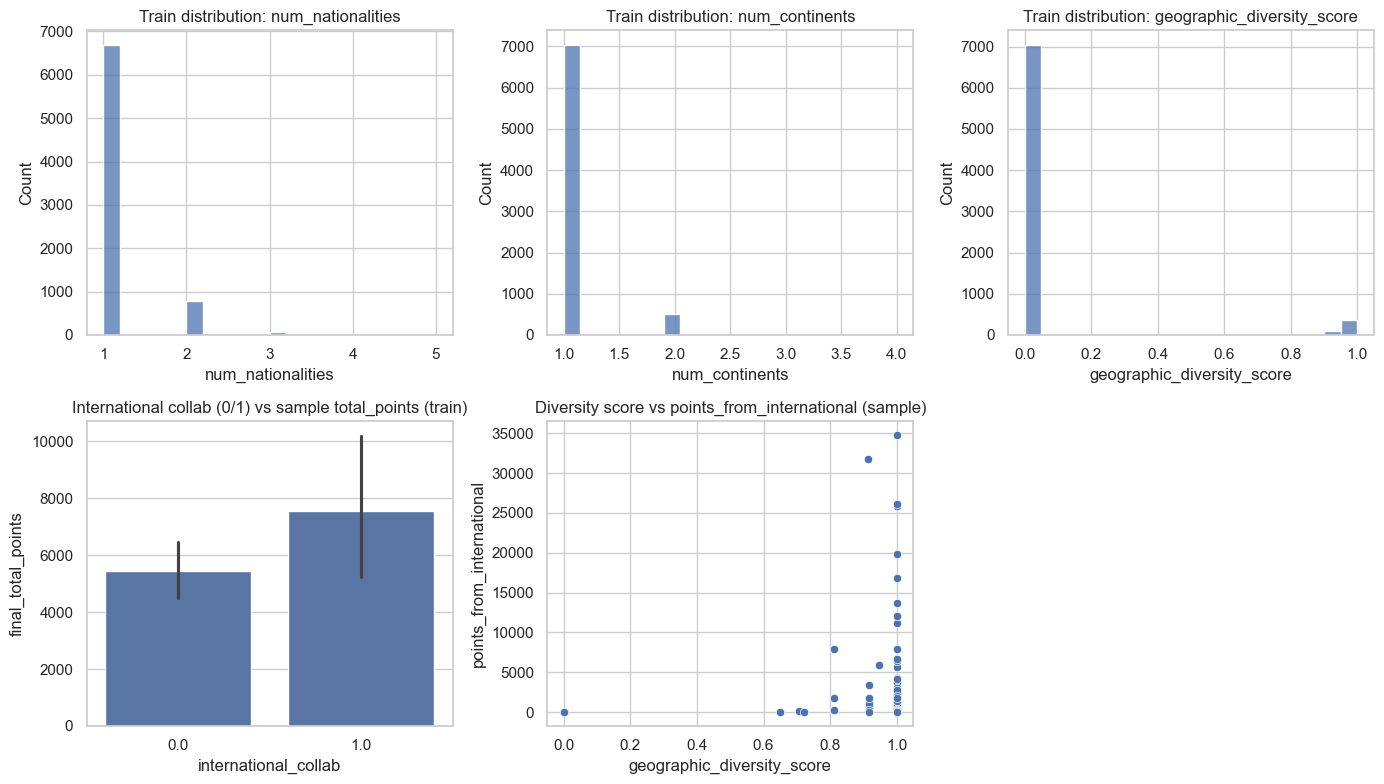

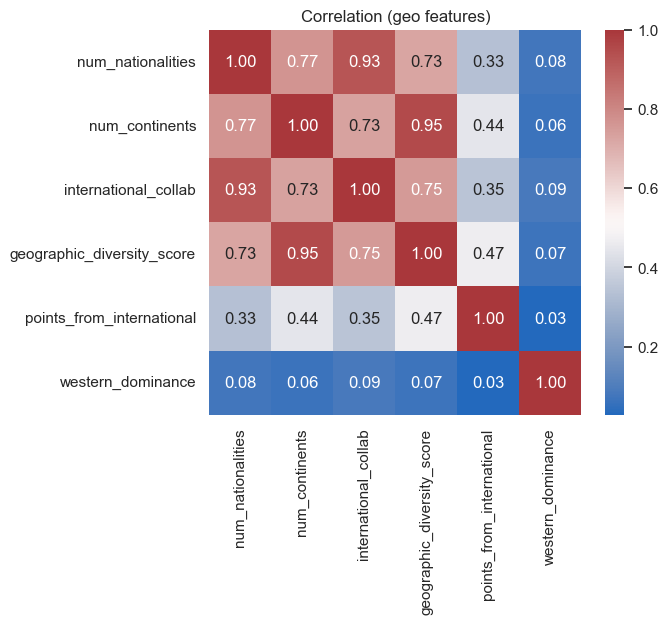

In [7]:
# Cell: EDA plots
geo_cols = ["num_nationalities","num_continents","international_collab","geographic_diversity_score","points_from_international","western_dominance"]

plt.figure(figsize=(14,8))
for i, col in enumerate(["num_nationalities","num_continents","geographic_diversity_score"]):
    plt.subplot(2,3,i+1)
    sns.histplot(train_df[col].dropna(), kde=False, bins=20)
    plt.title(f"Train distribution: {col}")

plt.subplot(2,3,4)
sns.barplot(x="international_collab", y="final_total_points", data=train_df.sample(min(1000, len(train_df))))
plt.title("International collab (0/1) vs sample total_points (train)")

plt.subplot(2,3,5)
sns.scatterplot(data=train_df.sample(min(1000, len(train_df))), x="geographic_diversity_score", y="points_from_international")
plt.title("Diversity score vs points_from_international (sample)")

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(train_df[geo_cols].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation (geo features)")
plt.show()


## Clustering: Trying K = 4 and K = 5
We standardize the geo features, run K-Means for k=4 and k=5, record inertia, silhouette, and Davies–Bouldin for train set. We pick the best k using silhouette + DB score heuristics.


In [8]:
# Cell: prepare features & scaler
feature_cols = ["num_nationalities","num_continents","international_collab","geographic_diversity_score","points_from_international","western_dominance"]
X_train = train_df[feature_cols].fillna(0).values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

def run_k_evaluate(X, k):
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels) if len(np.unique(labels))>1 else np.nan
    db = davies_bouldin_score(X, labels) if len(np.unique(labels))>1 else np.nan
    return km, labels, sil, db, km.inertia_

results = {}
for k in [4,5]:
    km, labels, sil, db, inertia = run_k_evaluate(X_train_scaled, k)
    results[k] = {"kmeans": km, "labels": labels, "silhouette": sil, "db": db, "inertia": inertia}
    print(f"k={k}: silhouette={sil:.4f}, davies_bouldin={db:.4f}, inertia={inertia:.2f}")

# Cell: pick K (simple heuristic)
k_pref = 5
# compare silhouette & db
if (results[4]["silhouette"] > results[5]["silhouette"]) and (results[4]["db"] <= results[5]["db"]):
    k_pref = 4
print("Chosen K:", k_pref)

kmeans = KMeans(n_clusters=k_pref, random_state=42, n_init=50)
kmeans.fit(X_train_scaled)
train_labels = kmeans.predict(X_train_scaled)
train_df = train_df.reset_index(drop=True)
train_df['cluster'] = train_labels

# # Transform and predict for val/test
# def transform_and_predict(df_subset):
#     X = df_subset[feature_cols].fillna(0).values
#     Xs = scaler.transform(X)
#     labels = kmeans.predict(Xs)
#     df_copy = df_subset.copy()
#     df_copy['cluster'] = labels
#     return df_copy

# val_df = transform_and_predict(val_df)
# test_df = transform_and_predict(test_df)


k=4: silhouette=0.9458, davies_bouldin=0.5406, inertia=8405.21
k=5: silhouette=0.9550, davies_bouldin=0.4576, inertia=4234.56
Chosen K: 5


## Cluster-level summaries and heuristic labels
We compute cluster medians and assign human-friendly labels using heuristics:
- *Global Hit*: multiple continents, high diversity, significant international points
- *Cross-Cultural Fusion*: international collaborations common
- *Western-Dominated*: high western_dominance
- *Local Hero*: single nationality/continent and low international points
- *Regional Specialist*: fallback


In [9]:
# Diagnostic 1: show columns and types
print("Columns list (first 50):")
print(train_df.columns.tolist()[:50])
print("\nColumn dtypes:")
print(train_df.dtypes)

# Show if any column name is not a string (e.g., tuple / object)
non_string_cols = [c for c in train_df.columns if not isinstance(c, str)]
print("\nNon-string column names (if any):", non_string_cols)

# Show a tiny sample of rows and exact types per cell for key columns used in agg
sample = train_df.head(5).copy()
print("\nSample head:")
display(sample)

# For each column used in aggregation, show the type of the values in the first row (helps detect dict/list)
cols_to_check = ['num_continents','num_nationalities','geographic_diversity_score','international_collab','points_from_international','western_dominance','total_points','song_id','cluster']
for c in cols_to_check:
    if c in train_df.columns:
        val = train_df[c].iloc[0]
        print(f"Column '{c}' exists — sample type: {type(val)} — value repr: {repr(val)[:200]}")
    else:
        print(f"Column '{c}' is MISSING from train_df")


Columns list (first 50):
['song_id', 'title', 'date', 'artist_list', 'num_artists', 'nationality_list', 'num_nationalities', 'continent_list', 'num_continents', 'canonical_continent', 'total_points', 'continent_points', 'international_collab', 'geographic_diversity_score', 'points_from_international', 'western_dominance', 'final_total_points', 'year', 'cluster']

Column dtypes:
song_id                               object
title                                 object
date                          datetime64[ns]
artist_list                           object
num_artists                            int64
nationality_list                      object
num_nationalities                      int64
continent_list                        object
num_continents                         int64
canonical_continent                   object
total_points                         float64
continent_points                      object
international_collab                 float64
geographic_diversity_score        

,song_id,title,date,artist_list,num_artists,nationality_list,num_nationalities,continent_list,num_continents,canonical_continent,total_points,continent_points,international_collab,geographic_diversity_score,points_from_international,western_dominance,final_total_points,year,cluster
0,000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),2017-03-24,[ZAYN],1,[United Kingdom],1,[Europe],1,Europe,161.0,{'Europe': 11741.0},0.0,0.0,0.0,1.0,11741.0,2017,2
1,003VDDA7J3Xb2ZFlNx7nIZ,YELL OH,2020-02-07,"[Trippie Redd, Young Thug]",2,[United States],1,[Anglo-America],1,Anglo-America,93.0,{'Anglo-America': 124.0},0.0,0.0,0.0,0.0,124.0,2020,0
2,003eoIwxETJujVWmNFMoZy,Growing Pains,2018-06-15,[Alessia Cara],1,[Canada],1,[Anglo-America],1,Anglo-America,110.0,{'Anglo-America': 903.0},0.0,0.0,0.0,0.0,903.0,2018,0
3,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,2020-08-15,[The Killers],1,[United States],1,[Anglo-America],1,Anglo-America,128.0,{'Anglo-America': 18441.0},0.0,0.0,0.0,0.0,18441.0,2020,0
4,00B7TZ0Xawar6NZ00JFomN,Best Life (feat. Chance The Rapper),2018-04-06,[Cardi B],1,[United States],1,[Anglo-America],1,Anglo-America,140.0,{'Anglo-America': 1284.0},0.0,0.0,0.0,0.0,1284.0,2018,0


Column 'num_continents' exists — sample type: <class 'numpy.int64'> — value repr: 1
Column 'num_nationalities' exists — sample type: <class 'numpy.int64'> — value repr: 1
Column 'geographic_diversity_score' exists — sample type: <class 'numpy.float64'> — value repr: 0.0
Column 'international_collab' exists — sample type: <class 'numpy.float64'> — value repr: 0.0
Column 'points_from_international' exists — sample type: <class 'numpy.float64'> — value repr: 0.0
Column 'western_dominance' exists — sample type: <class 'numpy.float64'> — value repr: 1.0
Column 'total_points' exists — sample type: <class 'numpy.float64'> — value repr: 161.0
Column 'song_id' exists — sample type: <class 'str'> — value repr: '000xQL6tZNLJzIrtIgxqSl'
Column 'cluster' exists — sample type: <class 'numpy.int32'> — value repr: 2


In [19]:
# Convert any non-string column names to strings (safe normalization)
new_cols = []
for c in train_df.columns:
    if isinstance(c, tuple):
        new_cols.append("_".join(map(str, c)))   # join tuple names
    else:
        new_cols.append(str(c))
train_df.columns = new_cols
print("Normalized columns — first 50:")
print(train_df.columns.tolist()[:50])


Normalized columns — first 50:
['song_id', 'title', 'date', 'artist_list', 'num_artists', 'nationality_list', 'num_nationalities', 'continent_list', 'num_continents', 'canonical_continent', 'total_points', 'continent_points', 'num_nationalities', 'num_continents', 'international_collab', 'geographic_diversity_score', 'points_from_international', 'western_dominance', 'final_total_points', 'year', 'cluster']


In [20]:
train_df

,song_id,title,date,artist_list,num_artists,nationality_list,num_nationalities,continent_list,num_continents,canonical_continent,...,continent_points,num_nationalities,num_continents,international_collab,geographic_diversity_score,points_from_international,western_dominance,final_total_points,year,cluster
0,000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),2017-03-24,[ZAYN],1,[United Kingdom],1,[Europe],1,Europe,...,{'Europe': 11741.0},1.0,1.0,0.0,0.0,0.0,1.0,11741.0,2017,3
1,003VDDA7J3Xb2ZFlNx7nIZ,YELL OH,2020-02-07,"[Trippie Redd, Young Thug]",2,[United States],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 124.0},1.0,1.0,0.0,0.0,0.0,0.0,124.0,2020,1
2,003eoIwxETJujVWmNFMoZy,Growing Pains,2018-06-15,[Alessia Cara],1,[Canada],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 903.0},1.0,1.0,0.0,0.0,0.0,0.0,903.0,2018,1
3,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,2020-08-15,[The Killers],1,[United States],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 18441.0},1.0,1.0,0.0,0.0,0.0,0.0,18441.0,2020,1
4,00B7TZ0Xawar6NZ00JFomN,Best Life (feat. Chance The Rapper),2018-04-06,[Cardi B],1,[United States],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 1284.0},1.0,1.0,0.0,0.0,0.0,0.0,1284.0,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7567,7zgqtptZvhf8GEmdsM2vp2,...Ready For It?,2017-09-04,[Taylor Swift],1,[United States],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 982.0},1.0,1.0,0.0,0.0,0.0,0.0,982.0,2017,1
7568,7zjEyeBsaw9gV0jofJLfOM,Livin It Up (with Post Malone & A$AP Rocky),2021-10-15,[Young Thug],1,[United States],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 209.0},1.0,1.0,0.0,0.0,0.0,0.0,209.0,2021,1
7569,7zl7kehxesNEo2pYkKXTSe,Killer (feat. Jack Harlow & Cordae) - Remix,2021-05-30,[Eminem],1,[United States],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 290.0},1.0,1.0,0.0,0.0,0.0,0.0,290.0,2021,1
7570,7znO2T2deQ7nZUbyxEAMDB,Be Yourself,2019-08-09,[Trippie Redd],1,[United States],1,[Anglo-America],1,Anglo-America,...,{'Anglo-America': 61.0},1.0,1.0,0.0,0.0,0.0,0.0,61.0,2019,1


In [21]:
# Ensure cluster exists
if 'cluster' not in train_df.columns:
    raise KeyError("train_df has no 'cluster' column. Assign cluster labels first (train_df['cluster'] = ...).")

# There may be columns missing or named differently; coerce common alternatives
if 'song_id' not in train_df.columns:
    if 'id' in train_df.columns:
        train_df = train_df.rename(columns={'id':'song_id'})
    else:
        # create a synthetic song id if none exists (index-based)
        train_df['song_id'] = train_df.index.astype(str)

# Safe conversions: try to coerce numeric-like columns to numeric
num_cols = ['num_continents','num_nationalities','geographic_diversity_score','international_collab','points_from_international','western_dominance','total_points']
for c in num_cols:
    if c in train_df.columns:
        # If column cells are list/dict, fallback to length or NaN
        sample_val = train_df[c].dropna().iloc[0] if train_df[c].dropna().shape[0] > 0 else None
        if isinstance(sample_val, (list, dict, set)):
            # replace lists/dicts by their length or sum if dict
            def safe_flat(x):
                if isinstance(x, list): return len(x)
                if isinstance(x, dict): return sum(x.values()) if all(isinstance(v, (int,float)) for v in x.values()) else np.nan
                return x
            train_df[c + "_safe"] = train_df[c].map(safe_flat)
            # point future aggregations to this safe column name
            train_df[c + "_safe"] = pd.to_numeric(train_df[c + "_safe"], errors='coerce')
        else:
            train_df[c] = pd.to_numeric(train_df[c], errors='coerce')

# Decide which column names to use for aggregation (prefer safe versions if created)
agg_map = {
    'num_continents': 'median',
    'num_nationalities': 'median',
    'geographic_diversity_score': 'median',
    'international_collab': 'mean',
    'points_from_international': 'median',
    'western_dominance': 'median',
    'total_points': 'median',
    'song_id': 'count'
}

# Replace with _safe versions if present
for base in ['num_continents','num_nationalities','points_from_international']:
    safe = base + "_safe"
    if safe in train_df.columns:
        train_df[safe] = pd.to_numeric(train_df[safe], errors='coerce')
        agg_map[safe] = agg_map.pop(base)
        # also remove original base from agg_map if present
        if base in agg_map: del agg_map[base]

# Now compute each aggregation separately and join them
grouped = train_df.groupby('cluster')

parts = {}
for col, aggfunc in agg_map.items():
    # compute and ensure result is a DataFrame
    try:
        s = grouped[col].agg(aggfunc).rename(col + "_" + str(aggfunc))
        parts[col] = s
    except Exception as e:
        print(f"Aggregation failed for column '{col}' with agg '{aggfunc}': {e}")
        # Try to compute manually for 'count' fallback or medians
        if aggfunc == 'count':
            parts[col] = grouped.size().rename('count')
        elif aggfunc in ('median','mean'):
            parts[col] = grouped[col].apply(lambda x: pd.to_numeric(x, errors='coerce').median() if aggfunc=='median' else pd.to_numeric(x, errors='coerce').mean()).rename(col + "_" + aggfunc)
        else:
            raise

# Merge parts into a single DataFrame
from functools import reduce
dfs = [parts[k] for k in parts.keys()]
cluster_summary_safe = reduce(lambda left,right: left.to_frame().join(right.to_frame()), dfs)
# Clean up column names
cluster_summary_safe.columns = [c.replace("_median","_median").replace("_mean","_mean").replace("_count","_count") for c in cluster_summary_safe.columns]
cluster_summary_safe = cluster_summary_safe.reset_index().rename(columns={
    # try to map the original desired names back
})
# If original mapping used 'song_id'->count, ensure 'count' column exists
if 'song_id' in agg_map and 'song_id_count' in cluster_summary_safe.columns:
    cluster_summary_safe = cluster_summary_safe.rename(columns={'song_id_count':'count'})
elif 'count' not in cluster_summary_safe.columns:
    # create count from group sizes
    cluster_summary_safe['count'] = train_df.groupby('cluster').size().values

cluster_summary_safe = cluster_summary_safe.reset_index(drop=True)
print("Aggregated cluster_summary (safe):")
display(cluster_summary_safe)


TypeError: arg must be a list, tuple, 1-d array, or Series

In [10]:
# Cell: cluster summaries
cluster_summary = train_df.groupby('cluster').agg({
    'num_continents':'median',
    'num_nationalities':'median',
    'geographic_diversity_score':'median',
    'international_collab':'mean',
    'points_from_international':'median',
    'western_dominance':'median',
    'total_points':'median',
    'song_id':'count'
}).rename(columns={'song_id':'count'}).reset_index()
cluster_summary


,cluster,num_continents,num_nationalities,geographic_diversity_score,international_collab,points_from_international,western_dominance,total_points,count
0,0,1.0,1.0,0.0,0.0,0.0,0.0,123.0,5201
1,1,2.0,2.0,1.0,1.0,421.5,0.5,116.0,474
2,2,1.0,1.0,0.0,0.0,0.0,1.0,97.0,1489
3,3,1.0,2.0,0.0,1.0,0.0,0.0,125.0,351
4,4,2.0,2.0,1.0,1.0,16831.0,0.5,193.0,57


In [11]:
# assign labels heuristically
def assign_cluster_name(row):
    if (row['num_continents'] >= 2 and row['geographic_diversity_score'] > 0.4 and row['points_from_international'] > 0):
        return "Global Hit"
    if (row['international_collab'] >= 0.5 and row['num_continents'] >= 1):
        return "Cross-Cultural Fusion"
    if (row['western_dominance'] >= 0.65 and row['num_continents'] <= 1):
        return "Western-Dominated"
    if (row['num_continents'] <= 1 and row['num_nationalities'] <= 1 and (row['points_from_international'] < (0.05 * max(1,row['total_points'])))):
        return "Local Hero"
    return "Regional Specialist"

cluster_summary['label'] = cluster_summary.apply(assign_cluster_name, axis=1)
cluster_to_label = dict(zip(cluster_summary['cluster'], cluster_summary['label']))


train_df['cluster_label'] = train_df['cluster'].map(cluster_to_label)
print("Train label counts:\n", train_df['cluster_label'].value_counts())

cluster_summary


Train label counts:
 cluster_label
Local Hero               5201
Western-Dominated        1489
Global Hit                531
Cross-Cultural Fusion     351
Name: count, dtype: int64


,cluster,num_continents,num_nationalities,geographic_diversity_score,international_collab,points_from_international,western_dominance,total_points,count,label
0,0,1.0,1.0,0.0,0.0,0.0,0.0,123.0,5201,Local Hero
1,1,2.0,2.0,1.0,1.0,421.5,0.5,116.0,474,Global Hit
2,2,1.0,1.0,0.0,0.0,0.0,1.0,97.0,1489,Western-Dominated
3,3,1.0,2.0,0.0,1.0,0.0,0.0,125.0,351,Cross-Cultural Fusion
4,4,2.0,2.0,1.0,1.0,16831.0,0.5,193.0,57,Global Hit


## 2D PCA projection of clusters (visualization)
We reduce standardized geographic features to 2D using PCA and plot points colored by cluster. We'll show cluster centroids and label each cluster on the plot.


C:\Users\racha\AppData\Local\Temp\ipykernel_19144\193559184.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=train_df['cluster_label'], palette=palette, s=30, alpha=0.7, edgecolor=None)


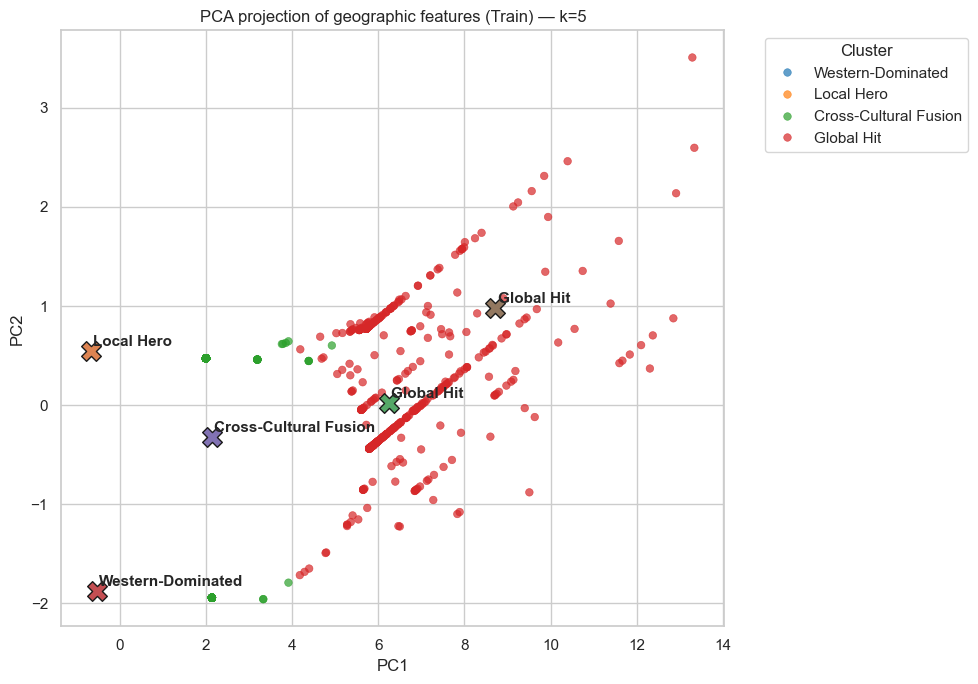

In [12]:
# Cell: PCA 2D and plotting
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_train_scaled)

# compute centroids in PCA space (transform kmeans.cluster_centers_)
centroids_scaled = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids_scaled)

plt.figure(figsize=(10,7))
palette = sns.color_palette("tab10", n_colors=k_pref)
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=train_df['cluster_label'], palette=palette, s=30, alpha=0.7, edgecolor=None)
# plot centroids
for i, (cx, cy) in enumerate(centroids_pca):
    label = cluster_to_label.get(i, str(i))
    plt.scatter(cx, cy, marker='X', s=200, edgecolor='k')
    plt.text(cx+0.05, cy+0.05, label, fontsize=11, weight='bold')

plt.title(f"PCA projection of geographic features (Train) — k={k_pref}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', title="Cluster")
plt.tight_layout()
plt.show()


## Evaluation Metrics

In [13]:
# Cell: compute metrics
def compute_metrics_for_df(df_subset):
    X = df_subset[feature_cols].fillna(0).values
    Xs = scaler.transform(X)
    labels = df_subset['cluster'].values
    sil = silhouette_score(Xs, labels) if len(np.unique(labels))>1 else np.nan
    db = davies_bouldin_score(Xs, labels) if len(np.unique(labels))>1 else np.nan
    return sil, db

train_sil, train_db = compute_metrics_for_df(train_df)
# val_sil, val_db = compute_metrics_for_df(val_df)
# test_sil, test_db = compute_metrics_for_df(test_df)

print("Train: Silhouette = {:.4f}, Davies-Bouldin = {:.4f}".format(train_sil, train_db))
# print("Val:   Silhouette = {:.4f}, Davies-Bouldin = {:.4f}".format(val_sil, val_db))
# print("Test:  Silhouette = {:.4f}, Davies-Bouldin = {:.4f}".format(test_sil, test_db))


Train: Silhouette = 0.9550, Davies-Bouldin = 0.4576


## Inspect sample songs per cluster
See representative songs from each cluster and their geographic breakdowns.


In [14]:
# Cell: sample per cluster
display_cols = ['song_id','title','date','artist_list','canonical_continent','num_nationalities','num_continents','geographic_diversity_score','points_from_international','cluster_label']
for cl in sorted(train_df['cluster'].unique()):
    label = cluster_to_label.get(cl, str(cl))
    print(f"\nCluster {cl} — {label} (n={len(train_df[train_df['cluster']==cl])})")
    display(train_df[train_df['cluster']==cl][display_cols].head(6))



Cluster 0 — Local Hero (n=5201)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
1,003VDDA7J3Xb2ZFlNx7nIZ,YELL OH,2020-02-07,"[Trippie Redd, Young Thug]",Anglo-America,1,1,0.0,0.0,Local Hero
2,003eoIwxETJujVWmNFMoZy,Growing Pains,2018-06-15,[Alessia Cara],Anglo-America,1,1,0.0,0.0,Local Hero
3,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,2020-08-15,[The Killers],Anglo-America,1,1,0.0,0.0,Local Hero
4,00B7TZ0Xawar6NZ00JFomN,Best Life (feat. Chance The Rapper),2018-04-06,[Cardi B],Anglo-America,1,1,0.0,0.0,Local Hero
8,00R0fEFZGb5hyTgF1nrRCq,Look Over Your Shoulder (feat. Kendrick Lamar),2020-10-30,[Busta Rhymes],Anglo-America,1,1,0.0,0.0,Local Hero
9,00TVmX9spquyg0UKuN57l3,HOLD ME TIGHT OR DON'T,2018-01-22,[Fall Out Boy],Anglo-America,1,1,0.0,0.0,Local Hero



Cluster 1 — Global Hit (n=474)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
7,00ETaeHUQ6lops3oWU1Wrt,Hot Stuff,2020-09-18,"[Kygo, Donna Summer]",Europe,2,2,1.000000,70.0,Global Hit
42,02LZ1fGJE8fB56yTlCVMEV,Switch,2017-05-19,"[Iggy Azalea, Anitta]",Oceania,2,2,1.000000,127.0,Global Hit
47,02kDW379Yfd5PzW5A6vuGt,Lemonade,2020-08-14,"[Internet Money, Gunna, Don Toliver, NAV]",Anglo-America,3,2,0.811278,506.0,Global Hit
63,03iCbZaM4OkRR4We6wIzvx,IDOL,2018-08-24,"[BTS, Nicki Minaj]",Asia,2,2,1.000000,951.0,Global Hit
71,042x9bsUBWW2fJgJ6fUh61,Not Going Home (feat. Gia Koka),2017-01-02,"[DVBBS, CMC$]",Anglo-America,2,2,1.000000,2125.0,Global Hit
79,04YutdH0j1INpsva3gOipt,MAMACITA,2020-06-19,"[Black Eyed Peas, Ozuna, J. Rey Soul]",Anglo-America,2,2,0.918296,60.0,Global Hit



Cluster 2 — Western-Dominated (n=1489)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
0,000xQL6tZNLJzIrtIgxqSl,Still Got Time (feat. PARTYNEXTDOOR),2017-03-24,[ZAYN],Europe,1,1,0.0,0.0,Western-Dominated
12,00lNx0OcTJrS3MKHcB80HY,You Don't Know Me - Radio Edit,2017-01-09,"[Jax Jones, RAYE]",Europe,1,1,0.0,0.0,Western-Dominated
17,017PF4Q3l4DBUiWoXk4OWT,Break My Heart,2020-03-27,[Dua Lipa],Europe,1,1,0.0,0.0,Western-Dominated
18,01BCvCKQNDmFQQQSjrzPnm,GHIGLIOTTI - feat. Noyz rcos,2021-10-01,[Salmo],Europe,1,1,0.0,0.0,Western-Dominated
21,01I9AEz658sQnQzCL3K3QG,HOES UP G'S DOWN,2020-05-29,[Shirin David],Europe,1,1,0.0,0.0,Western-Dominated
30,01hEpx8jnOG4q7nDK14Rhi,malibu,2021-05-14,[sangiovanni],Europe,1,1,0.0,0.0,Western-Dominated



Cluster 3 — Cross-Cultural Fusion (n=351)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
5,00Blm7zeNqgYLPtW6zg8cj,One Right Now (with The Weeknd),2021-11-05,"[Post Malone, The Weeknd]",Anglo-America,2,1,0.0,0.0,Cross-Cultural Fusion
6,00EPIEnX1JFjff8sC6bccd,No Me Acuerdo,2018-07-17,"[Thalia, Natti Natasha]",Latin-America,2,1,0.0,0.0,Cross-Cultural Fusion
46,02itaCXOdC54J0ISjqqFAp,All Around The World (La La La),2019-06-07,"[R3HAB, A Touch Of Class]",Europe,2,1,0.0,0.0,Cross-Cultural Fusion
56,03LfOYi0icz4souspZVVhq,"Nicky Jam: Bzrp Music Sessions, Vol. 41",2021-07-01,"[Bizarrap, Nicky Jam]",Latin-America,2,1,0.0,0.0,Cross-Cultural Fusion
57,03NqHNdG3Ur6kciQWK6e8V,Oh,2021-10-29,"[Myke Towers, Camila Cabello, Tainy]",Latin-America,2,1,0.0,0.0,Cross-Cultural Fusion
87,059bcIhyc2SBwm6sw2AZzd,Te Vi,2019-01-11,"[Piso 21, Micro TDH]",Latin-America,2,1,0.0,0.0,Cross-Cultural Fusion



Cluster 4 — Global Hit (n=57)


,song_id,title,date,artist_list,canonical_continent,num_nationalities,num_continents,geographic_diversity_score,points_from_international,cluster_label
75,04DwTuZ2VBdJCCC5TROn7L,In the name of Love,2017-01-01,"[Martin Garrix, Bebe Rexha]",Europe,2,2,1.000000,12019.0,Global Hit
147,08bNPGLD8AhKpnnERrAc6G,FRIENDS,2018-02-09,"[Marshmello, Anne-Marie]",Anglo-America,2,2,1.000000,27041.0,Global Hit
161,09IStsImFySgyp0pIQdqAc,The Middle,2018-01-26,"[Zedd, Maren Morris, Grey]",Anglo-America,2,2,0.918296,19921.0,Global Hit
258,0EhpEsp4L0oRGM0vmeaN5e,UN DIA (ONE DAY) (Feat. Tainy),2020-07-24,"[J Balvin, Dua Lipa, Bad Bunny]",Latin-America,3,2,0.918296,13712.0,Global Hit
372,0NiXXAI876aGImAd6rTj8w,Mama,2017-06-05,"[Jos Blue, William Singe]",Anglo-America,2,2,1.000000,16091.0,Global Hit
549,0YammaEkYSeo9vQYZ1OwS6,Say My me,2018-09-14,"[David Guetta, Bebe Rexha, J Balvin]",Europe,3,3,1.000000,13838.0,Global Hit


In [ ]:
# Save outputs for later use
out_dir = "./geo_clustering_outputs"
import os, joblib
os.makedirs(out_dir, exist_ok=True)

# Save dataframes
train_df.to_csv(os.path.join(out_dir, "songs_train_with_clusters.csv"), index=False)
cluster_summary.to_csv(os.path.join(out_dir, "cluster_summary.csv"), index=False)

# Save models / preprocessors
joblib.dump(scaler, os.path.join(out_dir, 'geo_scaler.joblib'))
joblib.dump(kmeans, os.path.join(out_dir, f'geo_kmeans{k_pref}.joblib'))

print("Saved outputs to", out_dir)


Saved outputs to ./geo_clustering_outputs
